# Background 
In this guided project, we'll be taking on the role of a trader on the S&P 500 futures desk. Our goal is to build a successful model to forecast how this index will move based on its past behavior. If we can make successful predictions, we can trade these futures effectively and lucratively.

The data has several potential columns for us to use for forecasting:

* Open: the opening value of the index on that day
* High: the highest value of the index on that day
* Low: the lowest value of the index on that day
* Close: the closing value of the index on that day
* Volume: the total volume of the index traded on that day
* Adj Close: the closing value of the index on that day adjusted for dividends

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Data Wrangling and Exploration

In [2]:
data = pd.read_csv('yahoo_stock.csv', index_col=0)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
data.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [4]:
data.shape

(1825, 6)

In [5]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [6]:
# Missing values
print('Number of null values: ', data.isnull().sum().sum())

Number of null values:  0


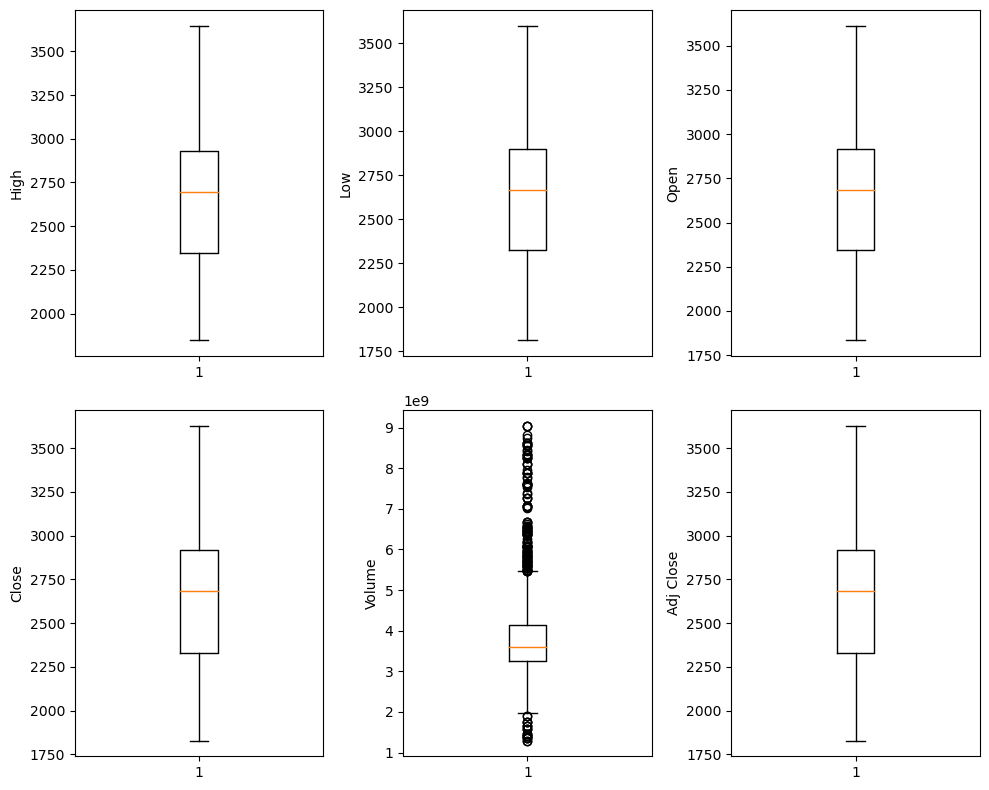

In [7]:
# Outliers

fig = plt.figure(figsize=(10, 8))

for i, col in enumerate(data.columns):
    ax = fig.add_subplot(2, 3, i+1)
    ax.boxplot(data[col])
    ax.set_ylabel(col)
    
plt.tight_layout()
plt.show()

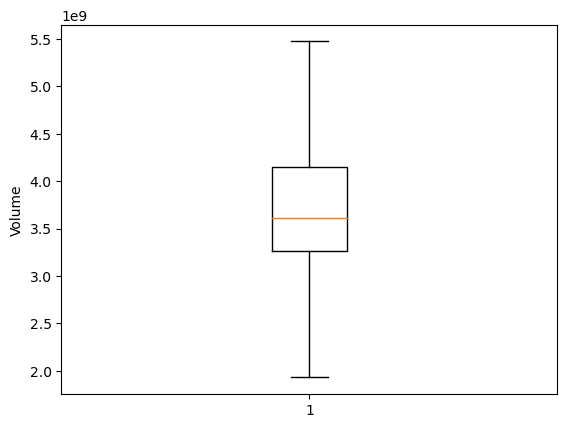

In [8]:
IQR = data.Volume.describe()[6] - data.Volume.describe()[4]
lower = data.Volume.describe()[4] - 1.5*IQR
upper = data.Volume.describe()[6] + 1.5*IQR

data.Volume = data.Volume.clip(lower, upper)
plt.boxplot(data.Volume)
plt.ylabel('Volume')
plt.show()

C:\Users\yuanl\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


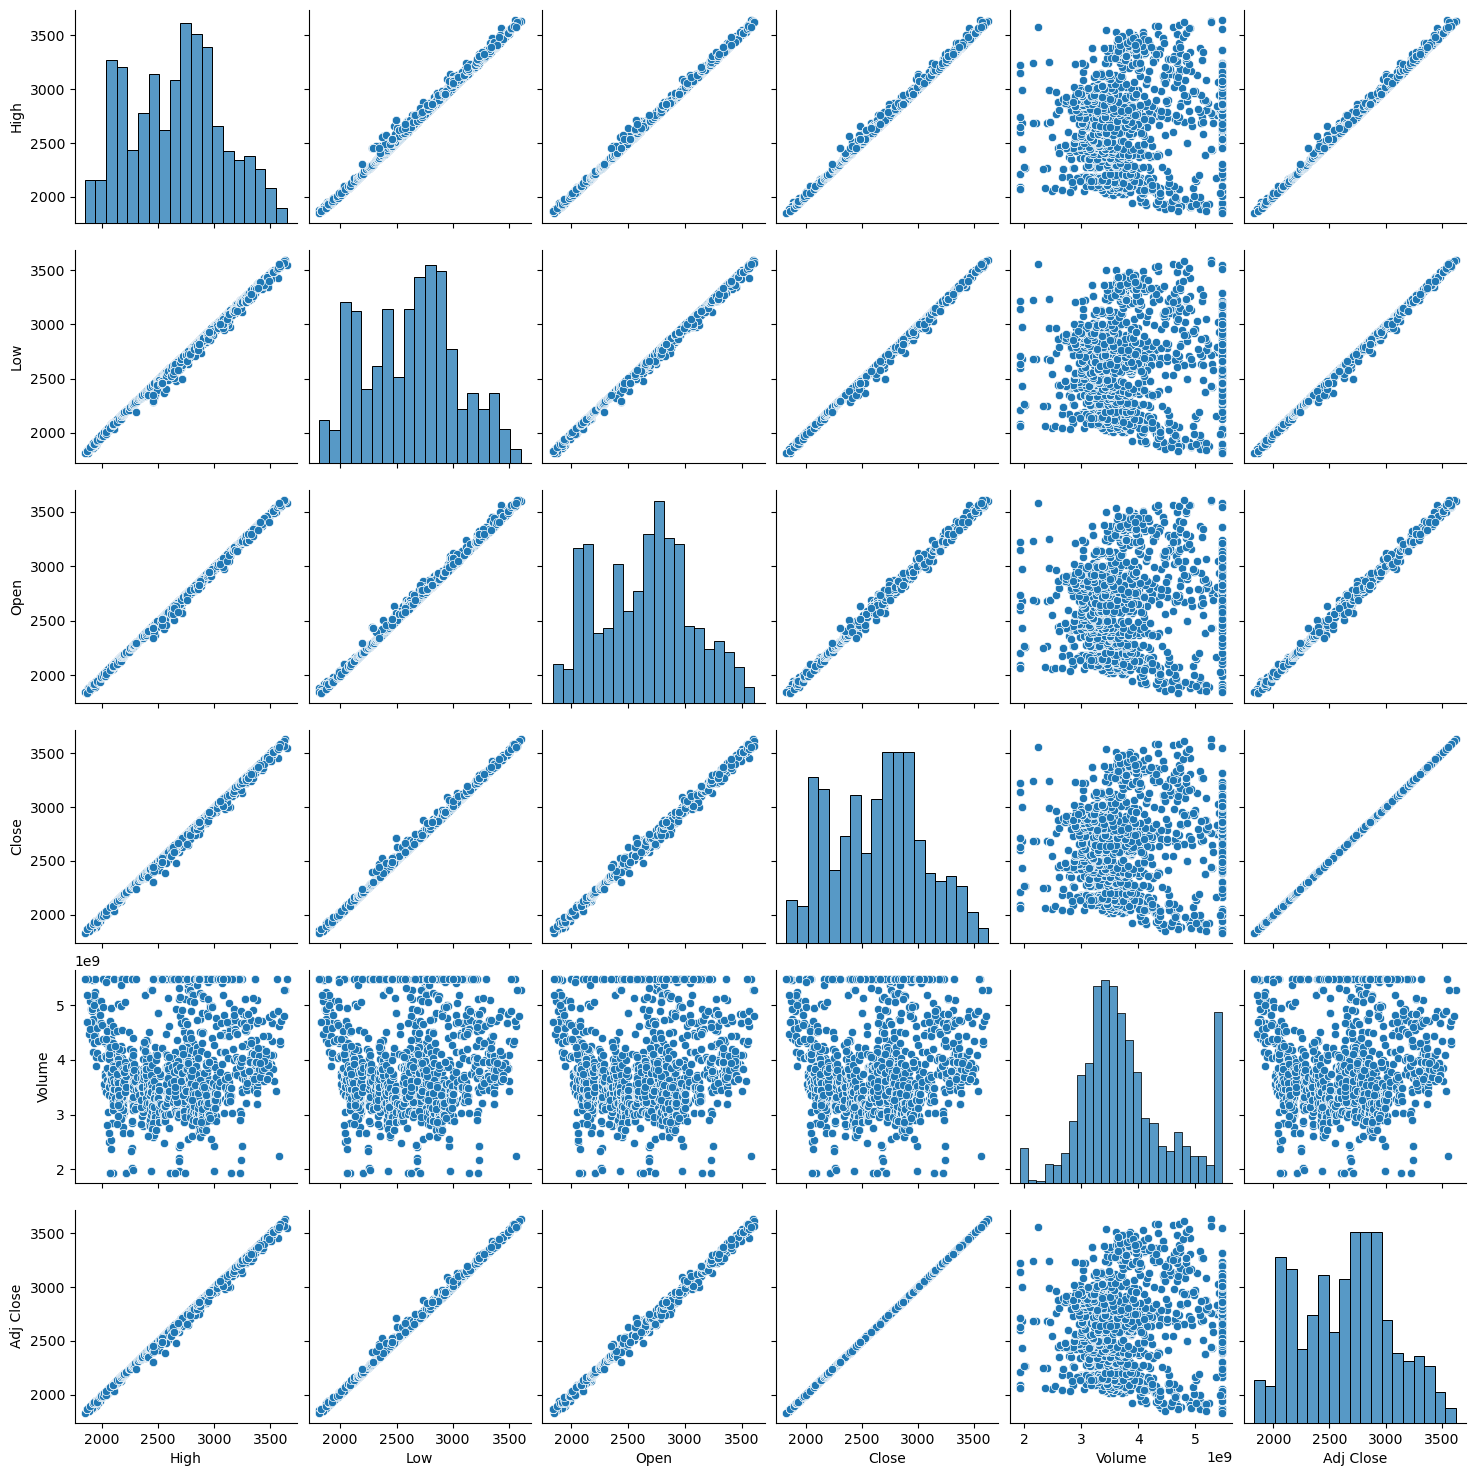

In [9]:
sns.pairplot(data)

<Axes: >

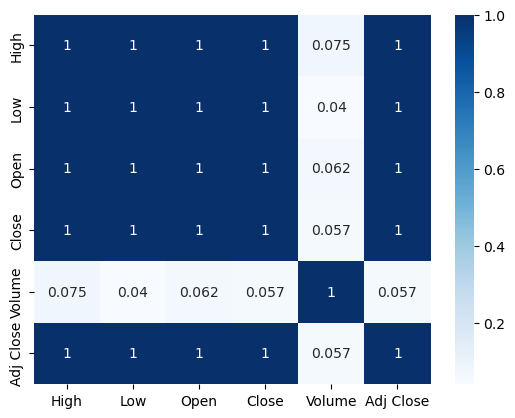

In [10]:
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='Blues')

The Open, High, Low, Close, Adj Close has Pearson r value of 1. Close is splitted for training and testing.

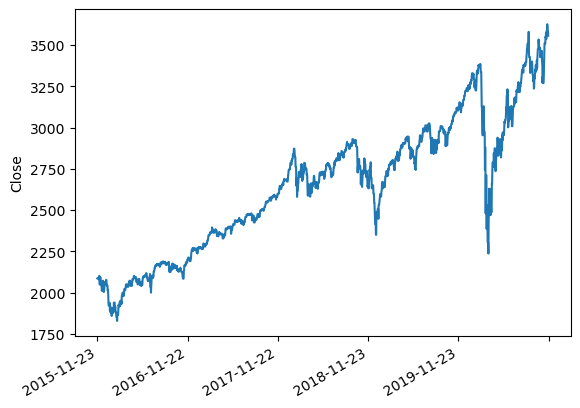

In [11]:
fig = plt.figure()

plt.plot(data.index, data.Close)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Close')

plt.show()


## Data Preprocessing
* 80% of the data for training 
* 10% for validation
* 10% for test

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
df = pd.DataFrame(data['Close'])

window_size = 10
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))

# Create train, validation, and test datasets, make the shape (, 1)
train = df.iloc[0:train_size, :]
validation = df.iloc[train_size: train_size+test_size, :]
test = df.iloc[train_size+test_size:len(df), :]

In [15]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [16]:
def split_data(data, window_size):
    data_x, data_y = [], []
    for i in range(len(data) - window_size -1):
        memory = data.iloc[i:i+window_size, 0]
        next_val = data.iloc[i+window_size, 0]
        data_x.append(memory)
        data_y.append(next_val)
    return np.array(data_x), np.array(data_y)

In [17]:
train_scaled = pd.DataFrame(scaler.transform(train), columns=['Close'], index=train.index)
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=['Close'], index=validation.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=['Close'], index=test.index)

In [18]:
window_size = 9
X_train, y_train = split_data(train_scaled, window_size)
X_val, y_val = split_data(validation_scaled, window_size)
X_test, y_test = split_data(test_scaled, window_size)

In [19]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Build and Train a Model

### SimpleRNN

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score

model = keras.Sequential()

model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

model.fit(X_train_reshaped, y_train)


# Metrics
train_pred = model.predict(X_train_reshaped)
val_pred = model.predict(X_val_reshaped)
test_pred = model.predict(X_test_reshaped)

print('R-square for training data: ', r2_score(y_train, train_pred))
print('R-square for validation data: ', r2_score(y_val, val_pred))
print('R-square for test data: ', r2_score(y_test, test_pred))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                200       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step
R-square for training data:  -2.207705120139318
R-square for training data:  -11.72264248706257
R-square for training data:  -75.34458977501858


SimpleRNN with one hidden layer: the r2 is negative. It performs very poor and needs to improve.

### LSTM

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = keras.Sequential()

model.add(layers.LSTM(128, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

model.fit(X_train_reshaped, y_train, epochs=200, verbose=0)

# Metrics
train_pred = model.predict(X_train_reshaped)
val_pred = model.predict(X_val_reshaped)
test_pred = model.predict(X_test_reshaped)

print('R-square for training data: ', r2_score(y_train, train_pred))
print('R-square for validation data: ', r2_score(y_val, val_pred))
print('R-square for test data: ', r2_score(y_test, test_pred))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               70656     
                                                                 
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dense_31 (Dense)            (None, 4)                 132       
                                                                 
 dense_32 (Dense)            (None, 1)                 5         
                                                                 
Total params: 74921 (292.66 KB)
Trainable params: 74921 (292.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
6/6 [==============================] - 0s 3ms/step
R-square for training data:  0.997029735295639
R-square for training data:  0.951995847406421
R-

Using LSTM, increasing the nodes, the r2 is between 0.94 and 0.99, very good!

### Add a CNN layer

In [40]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = keras.Sequential()

# Add a CNN layer

model.add(layers.Conv1D(128, 1, input_shape=(1, window_size), activation='relu'))
model.add(layers.MaxPooling1D(1))

model.add(layers.LSTM(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

model.fit(X_train_reshaped, y_train, epochs=30, verbose=0)

# Metrics
train_pred = model.predict(X_train_reshaped)
val_pred = model.predict(X_val_reshaped)
test_pred = model.predict(X_test_reshaped)

print('R-square for training data: ', r2_score(y_train, train_pred))
print('R-square for validation data: ', r2_score(y_val, val_pred))
print('R-square for test data: ', r2_score(y_test, test_pred))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 1, 128)            1280      
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 1, 128)            0         
 ng1D)                                                           
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dense_48 (Dense)            (None, 32)                4128      
                                                                 
 dense_49 (Dense)            (None, 16)                528       
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                     

The r-square for the validation and test dataset is between 0.93 and 0.95. 

### Data Visulization

In [41]:
# Un-scale the predict

train_pred = scaler.inverse_transform(model.predict(X_train_reshaped))
val_pred = scaler.inverse_transform(model.predict(X_val_reshaped))
test_pred = scaler.inverse_transform(model.predict(X_test_reshaped))

6/6 [==============================] - 0s 2ms/step


In [42]:
# Assign a train_pred dataset
df_train = np.empty((len(df), 1))
df_train[:] = np.nan
df_train[window_size:window_size+len(train_pred)] = train_pred

# Assign a validation_pred dataset
df_val= np.empty((len(df), 1))
df_val[:] = np.nan
df_val[2*window_size+len(train_pred): 2*window_size+len(train_pred)+len(val_pred)] = val_pred

# Assign a test_pred dataset
df_test = np.empty((len(df), 1))
df_test[:] = np.nan
df_test[3*window_size+len(train_pred)+len(val_pred): 3*window_size+len(train_pred)+len(val_pred)+len(test_pred)] = test_pred

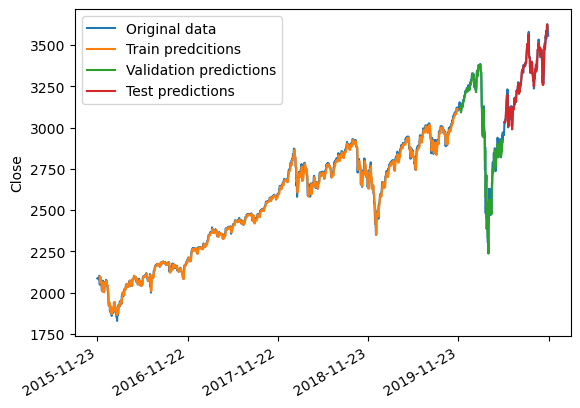

In [43]:
# Data Visualization

fig = plt.figure()

plt.plot(df, label='Original data')
plt.plot(df_train, label='Train predcitions')
plt.plot(df_val, label='Validation predictions')
plt.plot(df_test, label='Test predictions')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Close')
plt.legend()

plt.show()

The visualization looks great as the R_square is high.